In [2]:
import networkx as nx

import numpy as np
from scipy.sparse import csgraph
import scipy.signal as signal
import scipy.linalg as la
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import math
import time
import os

### Iz teorije grafova

In [3]:
def _Laplace_inDegree(G):
  A = nx.adjacency_matrix(G)
  A = np.transpose(A)
  D = np.diag(A @ np.ones(np.size(A,1)).transpose())
  return D-A;

In [41]:
def get_reaches(G):
    reaches = []
    visited = set()
    V = set(G.nodes())

    for node in V:
        if node not in visited:
            reach_set = set(nx.descendants(G, node)).union({node})
            visited.update(reach_set)
            reaches.append(reach_set)

    return reaches

In [52]:
def get_cabal(G, reach):
    cabal = set()
    for node in reach:
        reachable_set = set(nx.descendants(G,node)).union({node})
        if reach == reachable_set:
            cabal.add(node)
    return cabal

In [51]:
def get_common_part(G, reach):
    common_part = set()
    all_reaches = get_reaches(G)

    for node in reach:
        sees_other_reach = False
        for other_reach in all_reaches:
            if other_reach != reach:
                if node in other_reach:
                    sees_other_reach = True
                    break
        if sees_other_reach:
            common_part.add(node)

    return common_part

In [49]:
def get_exclusive_part(G, reach):
    exclusive_part = set()
    all_reaches = get_reaches(G)

    for node in reach:
        sees_other_reach = False
        for other_reach in all_reaches:
            if other_reach != reach and node in other_reach:
                sees_other_reach = True
                break
        if not sees_other_reach:
            exclusive_part.add(node)

    return exclusive_part

In [69]:
def graph_struct(G):
    struc = []
    reaches = get_reaches(G)
    for i,reach in enumerate(reaches):
        cabal = get_cabal(G,reach)
        comm = get_common_part(G,reach)
        excl = get_exclusive_part(G,reach)
        
        dict_ = {
            "R"+str(i+1): reach,
            "B"+str(i+1): cabal,
            "C"+str(i+1): comm,
            "H"+str(i+1): excl
        }
        struc.append(dict_)
    return struc

def print_graph_struct(struc):
    for i,r in enumerate(struc):
        for key in struc[i].keys():
            print(key, "=",r[key])
        print("")

### Iz teorije upravljanja

In [4]:
def mu_(alpha, beta, gamma):
    def mu(s):
        return (s*s-1j*s*beta)/(gamma + 1j*alpha*s);
    return mu;

In [76]:
def get_Fi_norm(G):
    L = _Laplace_inDegree(G)
    ndim = np.shape(L)[0];
    T,Z,dim_Ker_L = la.schur(L, sort = lambda x: abs(x)<1e-12)
    max_diagonal = np.max(np.abs(np.diag(T)))
    #print("- - - - - Računam Schurovu dekompoziciju")
    V = Z[:,dim_Ker_L:]
    EYE = np.diag(np.ones(ndim - dim_Ker_L))
    
    def FF_(i,alpha,beta,gamma):
        alpha_2 = alpha*alpha
        gamma_2 = gamma*gamma
        M = mu_(alpha,beta,gamma)
        VTei = V.T.conj()[:,i-1]
        Z_Tei = Z.T.conj()[dim_Ker_L:,i-1]
        
        def Fi(s):
            if (s == 0):
                #A = T[dim_Ker_L:,dim_Ker_L:] #uzmemo T_22
                x = la.solve_triangular(T[dim_Ker_L:,dim_Ker_L:],VTei)  #solve_triangular poziva
                #LAPACK rutinu za trokutasti sustav
                nrm =la.norm(V @ x /gamma)
                F = nrm
            else:
                x = la.solve_triangular(T[dim_Ker_L:,dim_Ker_L:] - EYE*M(s),Z_Tei)
                F = la.norm(V @ x)/np.sqrt(s*s*alpha_2 + gamma_2)
            return F;
        return Fi;
    return FF_, dim_Ker_L, ndim, max_diagonal;

### Unos grafova

In [18]:
def import_graphs_from_folder_with_index(folder_path):
    GRAPHS = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".gexf"):
            file_path = os.path.join(folder_path, file_name)
            
            split_parts = file_path.split("_")
            i = int(split_parts[2].split("=")[1])
            graph_name1 = "_".join(split_parts[3:])
            graph_name = graph_name1.split(".gexf")[0]
            # Read the graph from the file
            G = nx.read_gexf(file_path)
            tup = (G,graph_name,i)
            # Append the graph to the graphs list
            GRAPHS.append(tup)

    return GRAPHS

In [19]:
# Example usage
folder_path = "Graphs/"
imported_graphs = import_graphs_from_folder_with_index(folder_path)

In [21]:
# Print the list of imported graphs
#k = 0;
#for graph in imported_graphs:
#    print(k,graph[1])
#    print("   ")
#    k = k+1

In [126]:
def analyze_graph(graph):
    struc = graph_struct(graph[0])
    #print_graph_struct(struc)
    alpha = 1
    beta = 1
    sys_f, Kernel_dim, ndim, L_sigma = get_Fi_norm(graph[0])
    x0 = 0.1
    left_end = 0.0
    right_end = L_sigma * 10
    bounds = [(left_end, right_end)]
    
    not_in_list = True
    arg_i = -1   
    indexi = []
    maxi_arg = []
    gamma_0 = 0.01
    dict_ = {}
    for k in range(1, 11):
        gamma = k / 10
        norm_values = []
        
        for i in range(ndim):
            Fi = sys_f(i, alpha, beta, gamma)
            res = minimize(lambda s: -Fi(s), x0, bounds=bounds, method='Nelder-Mead')
            s_opt = res.x[0]
            norm = -res.fun
            norm_values.append(norm)
            
            if s_opt == 0.0:
                continue            
            elif not_in_list:
                not_in_list = False
                indexi.append(i)
                gamma_0 = gamma
        arg_stari = arg_i
        maxi = max(norm_values)
        arg_i = norm_values.index(maxi)
        if (arg_stari == -1):
            maxi_arg.append(arg_i)
        elif (arg_i != arg_stari):
            print(arg_i,arg_stari)
            print("promjena arg_max_i")
            maxi_arg.append(arg_i)
            
    if not not_in_list:
        #print("arg_maxF_i = ",maxi_arg)
        #print("[indeks prije,indeks sada] = [", graph[2],indexi,"]")
        #dict_["arg_max_i"] = maxi_arg
        #dict_["gamma_0"] = gamma
        #dict_["indexi"] = indexi
        ttt = 1
        
    return (maxi_arg, gamma_0, indexi)

In [ ]:
    not_in_list = True
    arg_i = -1   
    indexi = []
    maxi_arg = []
    gamma_0 = 0.01
    dict_ = {}
    for k in range(1, 11):
        gamma = k / 10
        norm_values = []
        
        for i in range(ndim):
            Fi = sys_f(i, alpha, beta, gamma)
            res = minimize(lambda s: -Fi(s), x0, bounds=bounds, method='Nelder-Mead')
            s_opt = res.x[0]
            norm = -res.fun
            norm_values.append(norm)
            
            if s_opt == 0.0:

In [ ]:
def export_graphs(CounterExamples_1, start_index):
    j = start_index

    for i in CounterExamples_1:
        print("   gamma=", i[2], " tip: ", i[1])
        if i[2] == 1.0:
            Graf, opis, gamma, indexi, optimal_s, ranges, obj_values, args, poruka, norm_values = i
            filename = f"{j+1:02d}_gamma={gamma}_i={indexi[0]}_{opis}.gexf"
            # nx.write_gexf(Graf, filename)
            print(j+1, "   gamma=", i[2], "; tip:", i[1])
            j += 1

In [139]:
def s_gamma_plot(item,j):
    G = item["graf"]
    opis = item["opis"]
    gamma_0 = item["gamma_0"]
    indexi = item["indexi"]
    
    alpha = 1
    beta = 1
    sys_f, Kernel_dim, ndim, L_sigma = get_Fi_norm(G)
    x0 = 0.1
    left_end = 0.0
    right_end = L_sigma * 10
    bounds = [(left_end, right_end)]
    gamma = gamma_0-0.09
    for i in indexi:
        s_opt_values = []
        gamma_values = []
        while(gamma <=1.0):
            Fi = sys_f(i, alpha, beta, gamma)
            res = minimize(lambda s: -Fi(s), x0, bounds=bounds, method='Nelder-Mead')
            s_opt = res.x[0]
            gamma_values.append(gamma)
            s_opt_values.append(s_opt)
            gamma = gamma+0.01
            
        plt.figure(figsize=(3,3))
        plt.plot(gamma_values,s_opt_values)
        plt.xlabel('gamma')
        plt.ylabel('s_opt')
        plt.title(opis)
        filename = f"Plots/{j:02d}_i={indexi[0]}_{opis}.png"
        plt.savefig(filename)
        plt.show()


 1


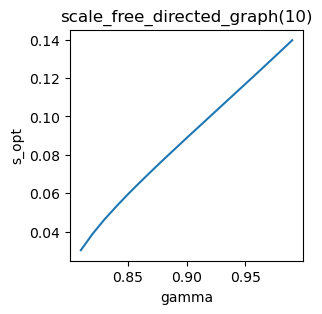


 2


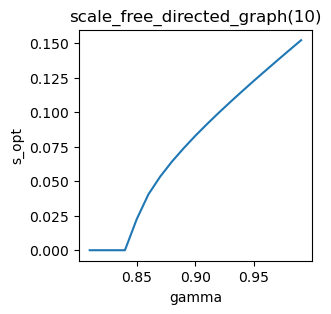


 3


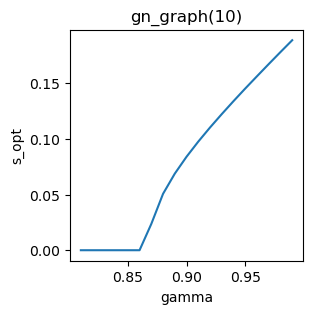


 4


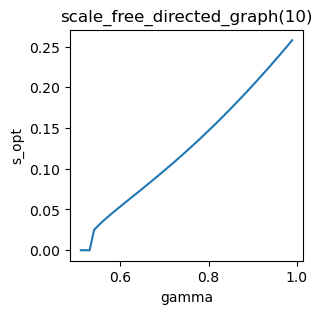


 5


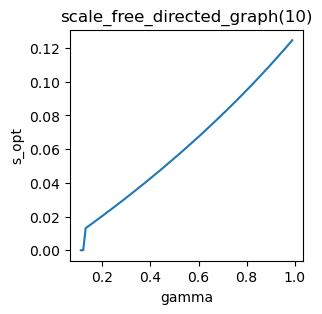


 6


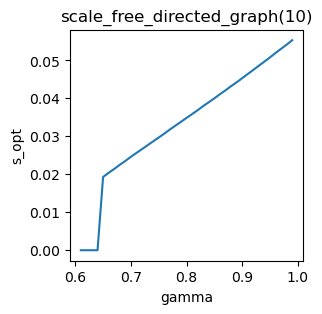


 7


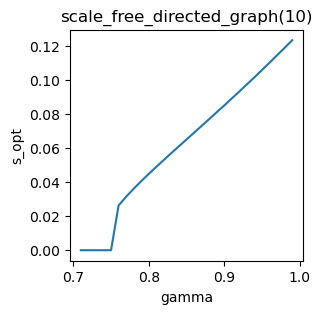


 8


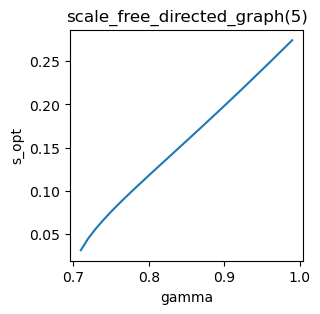


 9


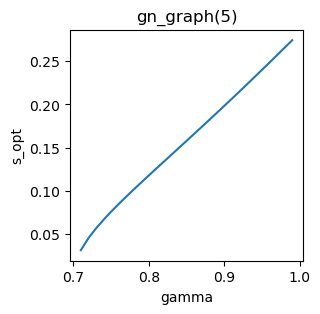


 10


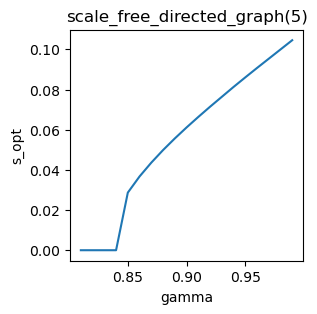


 11


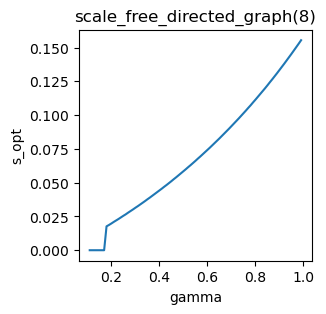


 12


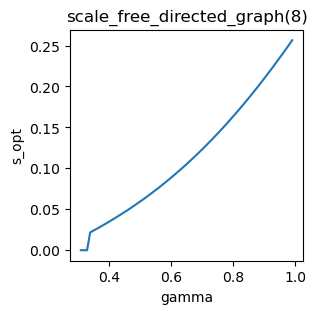


 13


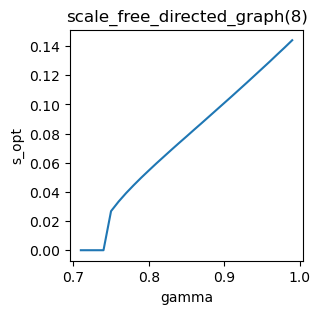


 14


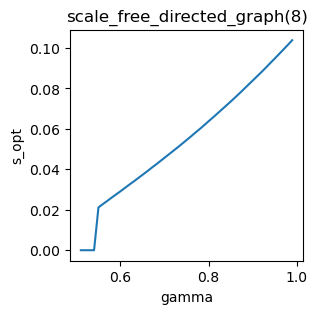


 15


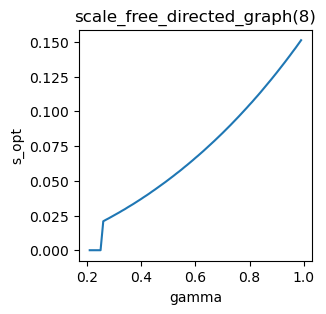


 16


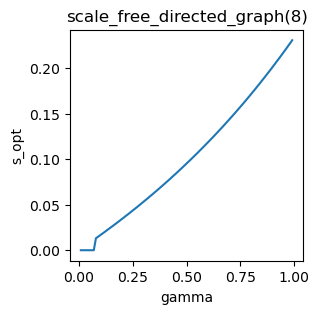


 17


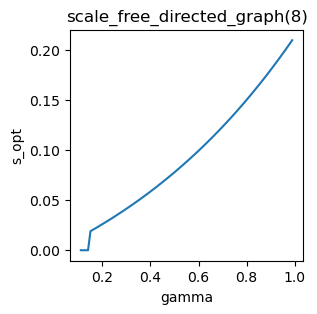


 18


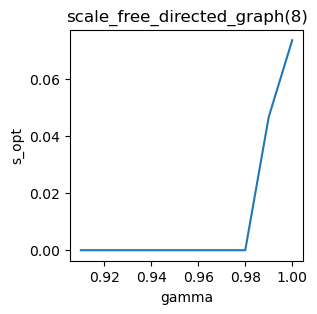


 19


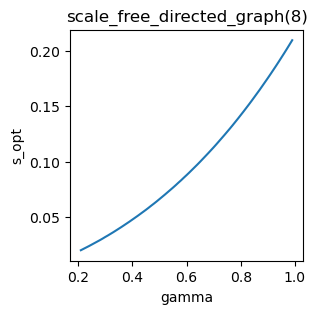


 20


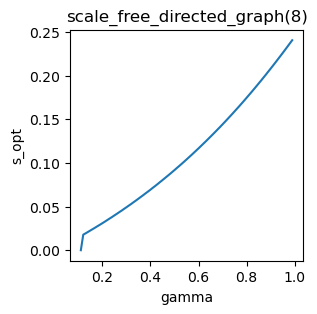


 21


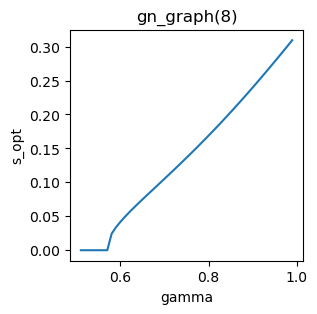


 22


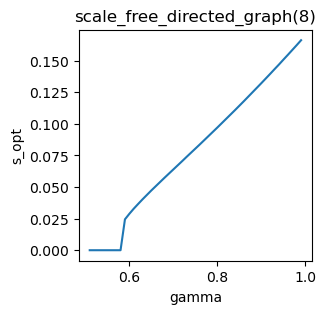


 23


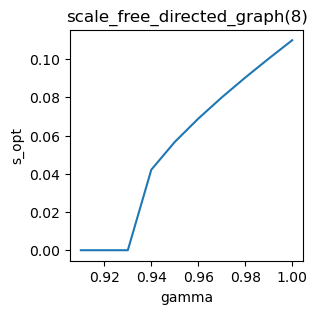


 24


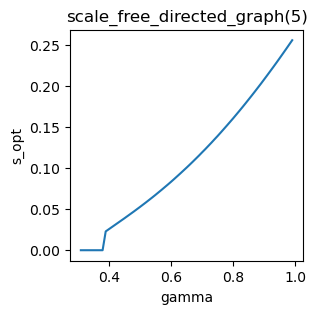


 25


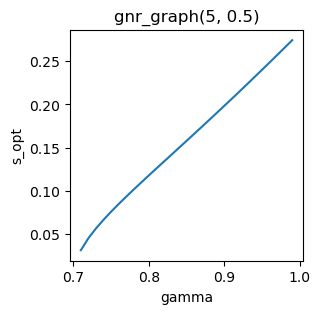


 26


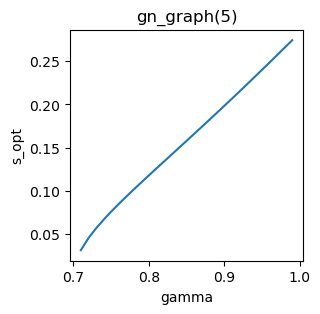


 27


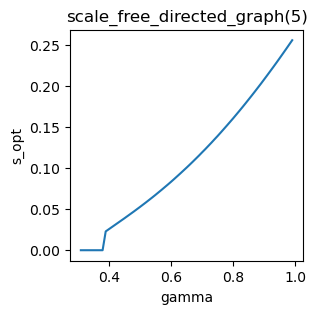


 28


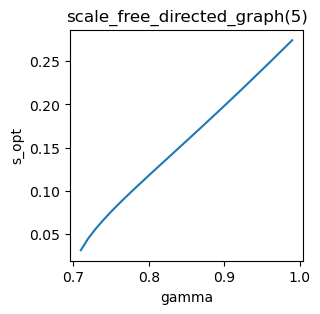


 29


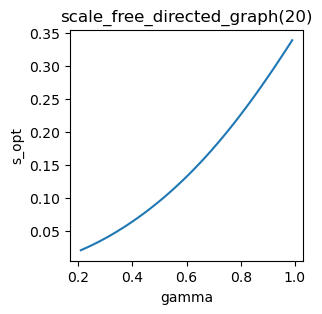


 30


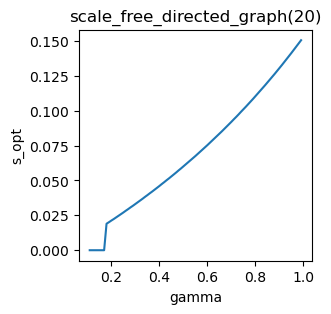


 31


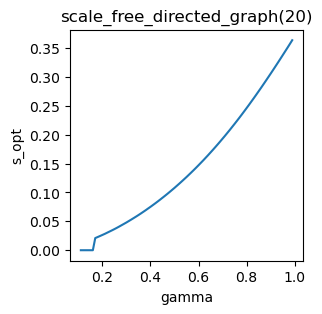


 32


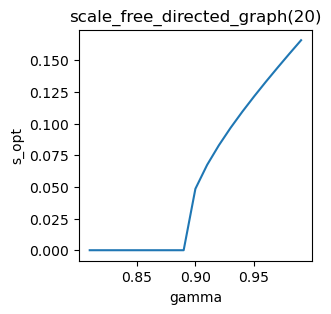


 33


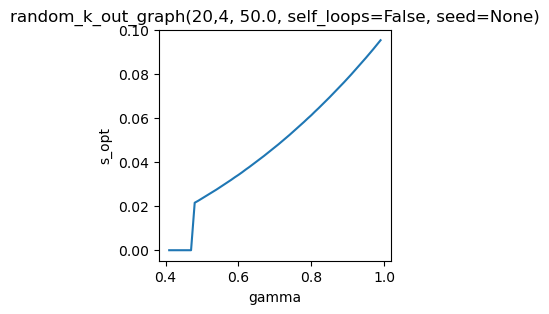


 34


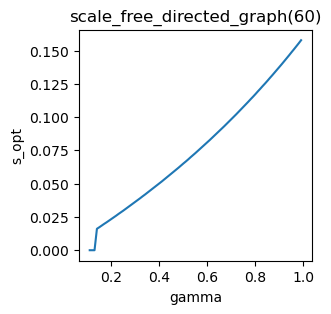


 35


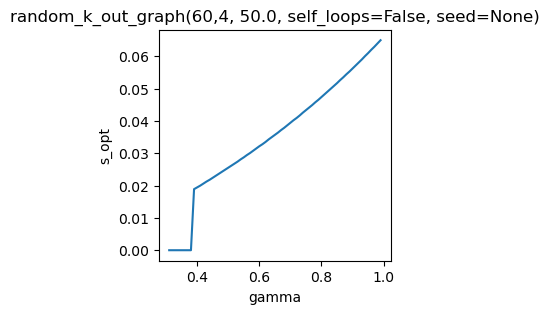


 36


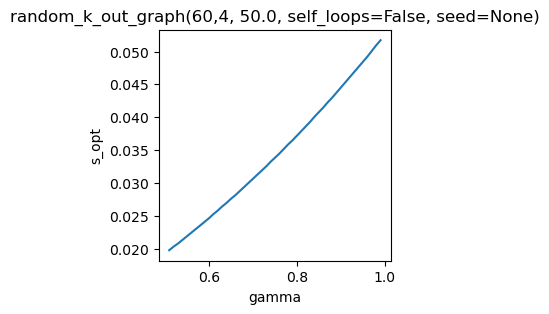


 37


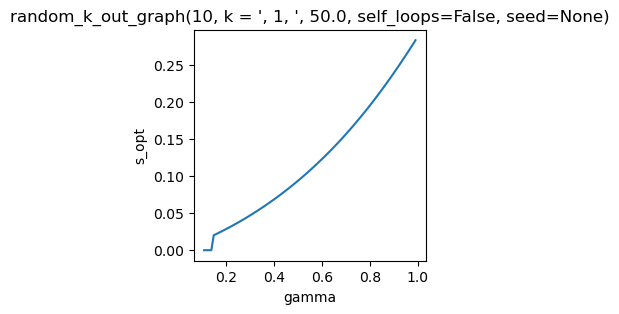


 38


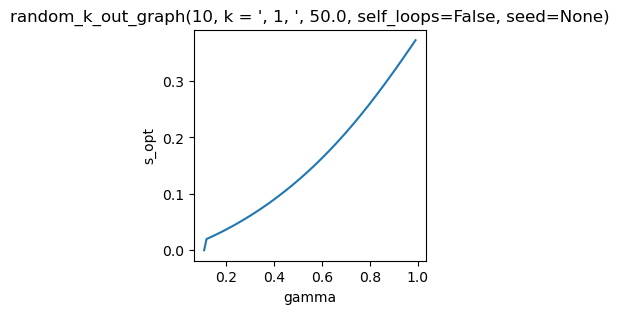


 39


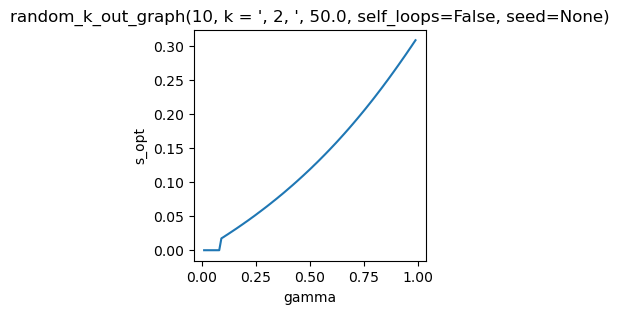


 40


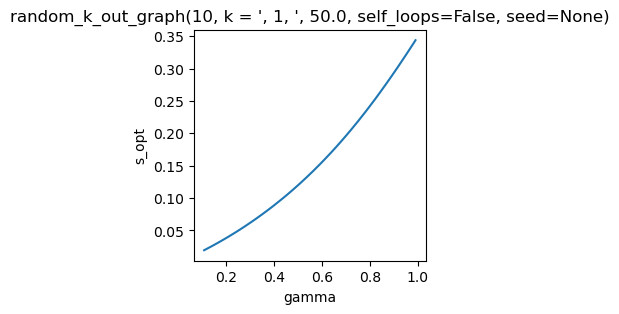


 41


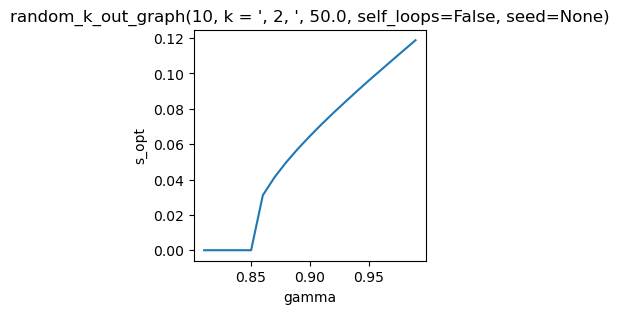


 42


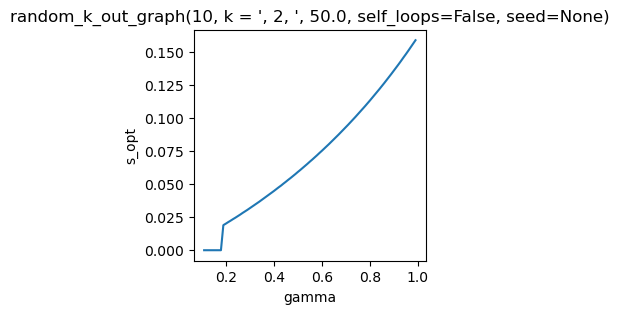


 43


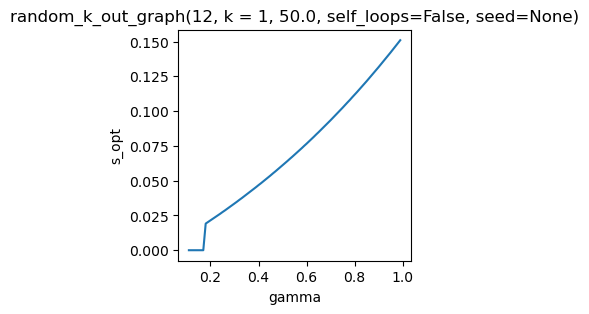


 44


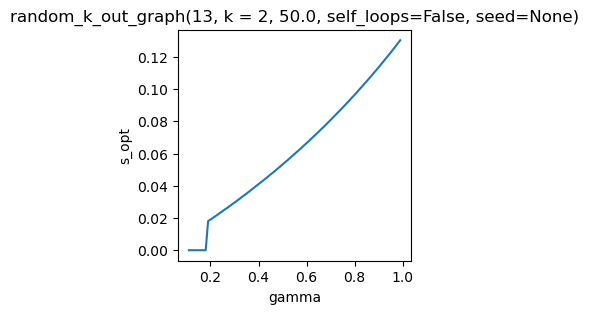


 45


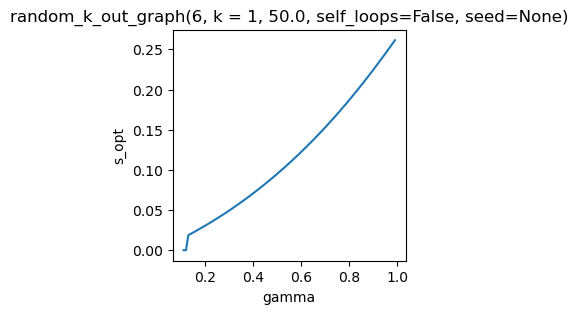


 46


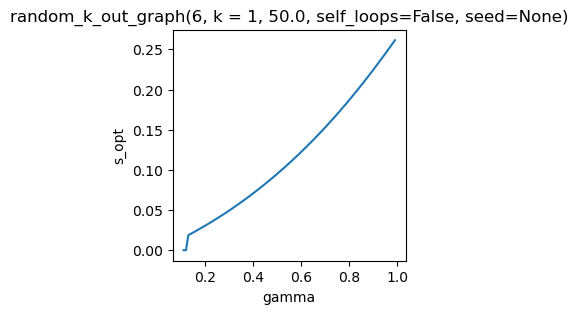


 47


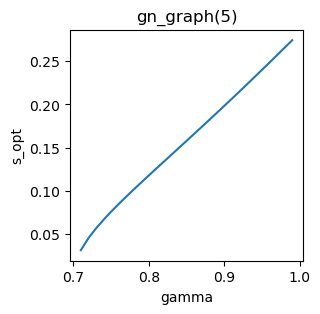


 48


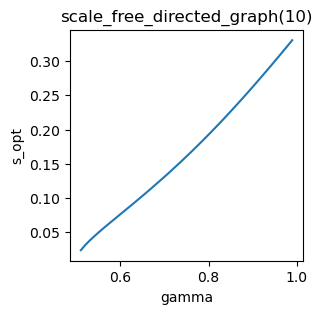


 49


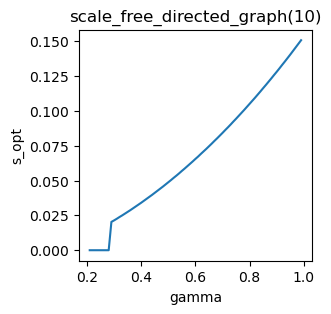


 50


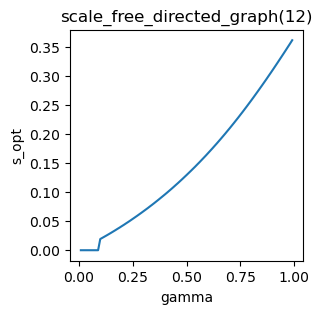


 51


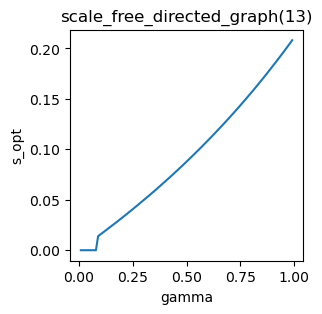


 52


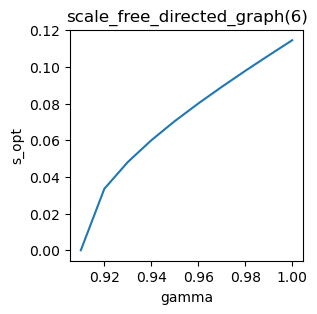


 53


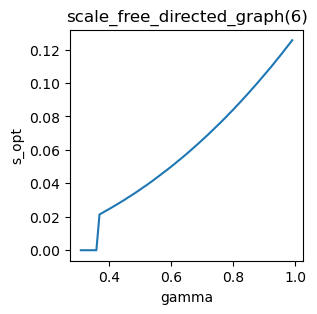


 54


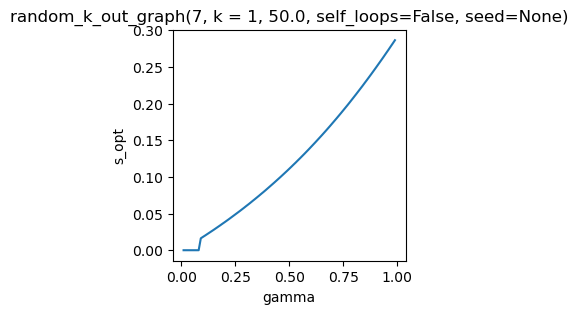


 55


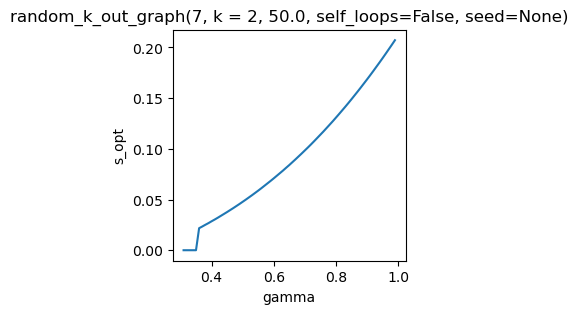


 56


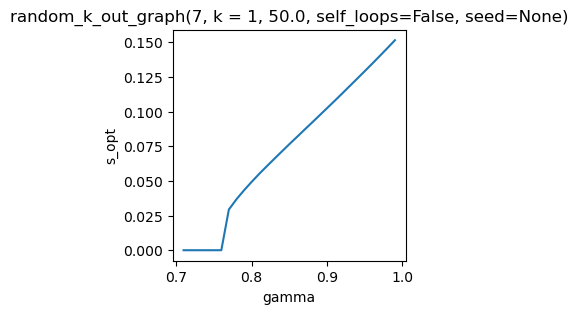


 57


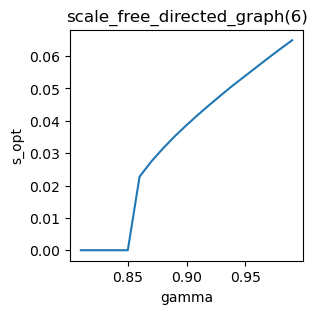


 58


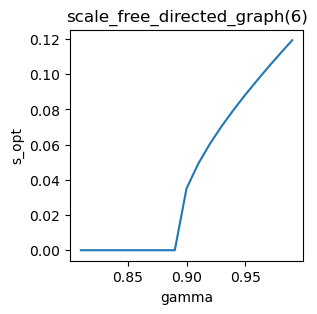


 59


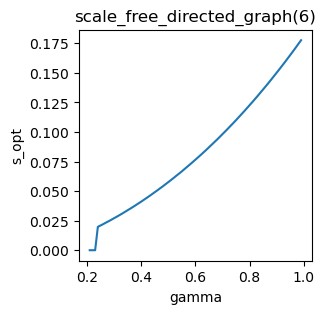

In [140]:
j = 1;
graph_collection = []

for G in imported_graphs:
    dict_ = {"graf":G[0],"opis":G[1]}
    print("\n",j)    
    T = analyze_graph(G)
    dict_["arg_max_i"] = T[0]
    dict_["gamma_0"] = T[1]
    dict_["indexi"] = T[2]
    graph_collection.append(dict_)
    s_gamma_plot(graph_collection[j-1],j)
    #print(graph_collection[j-1])
    j = j+1
    #if j==20:
    #    break

In [48]:
Veerman = nx.DiGraph()
Veerman.add_edges_from([(1, 2), (1, 6), (6, 7), (7, 6), (3, 7), (3, 4), (4, 5), (5, 3)])

Veerman_reaches = get_reaches(Veerman)
for reach in Veerman_reaches:
    print("\nR =", reach)
    Ve_cabal = get_cabal(Veerman,reach)
    print("B =",Ve_cabal)
    Ve_common = get_common_part(Veerman,reach)
    print("C =",Ve_common)
    Ve_excl = get_exclusive_part(Veerman,reach)
    print("H =",Ve_excl)


R = {1, 2, 6, 7}
B = {1}
C = {6, 7}
H = {1, 2}

R = {3, 4, 5, 6, 7}
B = {3, 4, 5}
C = {6, 7}
H = {3, 4, 5}


In [70]:
struc = graph_struct(Veerman)
print(struc)

[{'R1': {1, 2, 6, 7}, 'B1': {1}, 'C1': {6, 7}, 'H1': {1, 2}}, {'R2': {3, 4, 5, 6, 7}, 'B2': {3, 4, 5}, 'C2': {6, 7}, 'H2': {3, 4, 5}}]


In [72]:
print_graph_struct(struc)

R1 = {1, 2, 6, 7}
B1 = {1}
C1 = {6, 7}
H1 = {1, 2}

R2 = {3, 4, 5, 6, 7}
B2 = {3, 4, 5}
C2 = {6, 7}
H2 = {3, 4, 5}



def analyze_graph(graph):
    struc = graph_struct(graph[0])
    print_graph_struct(struc)
    alpha = 1
    beta = 1
    sys_f, Kernel_dim, ndim, L_sigma = get_Fi_norm(graph[0])
    x0 = 0.1
    left_end = 0
    right_end = L_sigma * 10
    spacing0 = 0.001
    spacing1 = 0.1
    bounds = [(left_end, right_end)]
    not_in_list = True
    arg_i = -1   
    indexi = []
    for k in range(1, 11):
        gamma = k / 10
        obj_values = []
        norm_values = []
        optimal_s = []
        ranges = []
        args = []
        
        for i in range(ndim):
            Fi = sys_f(i, alpha, beta, gamma)
            res = minimize(lambda s: -Fi(s), x0, bounds=bounds, method='Nelder-Mead')
            s_opt = res.x[0]
            norm = -res.fun
            norm_values.append(norm)
            
            #dio za kontrolu Nelder-Meada i za crtanje
            #if s_opt == 0.0:
            #    s_range = np.arange(left_end, right_end, spacing1)
            #else:
            #    s_range = np.arange(left_end, s_opt, spacing0)
            #    s_range = np.concatenate((s_range, np.arange(s_opt, s_opt * 5, spacing0)))
            
            #vals = [Fi(s) for s in s_range]
            #maxi = max(vals)
            #arg = vals.index(maxi)
            if
            #if arg != 0 and not_in_list:
            #    not_in_list = False
            #    indexi.append(i)
            #    #continue
            #    ranges.append(s_range)
            #    optimal_s.append(s_opt)
            #    obj_values.append(vals)
            #    args.append(arg)
            #    poruka = "Nađen kontraprimjer. gamma = " + str(gamma) + \
            #             "    (i, s_opt, s_range[arg], arg) = " + str(i) + \
            #             "," + str(s_opt) + ", " + str(s_range[arg]) + ", " + str(arg)
            #elif s_opt != s_range[arg] and not_in_list:
            #    print("Nelder-Mead zapeo")
            #    not_in_list = False
            #    indexi.append(i)
            #    #continue
            #    ranges.append(s_range)
            #    optimal_s.append(s_opt)
            #    obj_values.append(vals)
            #    args.append(arg)
            #    poruka = "Nađen kontraprimjer. Nelder-Mead zapeo u lok. ekstremu. gamma = " + str(gamma) + \
            #             "    (i, s_opt, s_range[arg], arg) = " + str(i) + \
            #             "," + str(s_opt) + ", " + str(s_range[arg]) + ", " + str(arg)
        maxi = max(norm_values)
        arg_i = norm_values.index(maxi)
            
    if not not_in_list:
        #CounterExamples_1.append((graph, graph_type, gamma, indexi, optimal_s, ranges, obj_values, args, poruka, norm_values))
        #print("Tip grafa:", graph_type)
        #print("       ", poruka)
        #plot_graph(graph)
        print("arg_maxF_i = ",arg_i)
        print("[indeks prije,indeks sada] = [", graph[2],indexi,"]")
    
    
    return indexi